In [1]:
from fastai.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *
from pm25.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(4)
    print(torch.cuda.get_device_name())

GeForce RTX 2080 Ti


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images

In [3]:
npz_fp = '/data/wangshuo/data/air-quality/chengyun/pm2.5_data.npz'

In [4]:
ds = PM(npz_fp)

In [5]:
train_tl = TfmdLists(range(len(ds)), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(len(ds)), ImageTupleTransform(ds))

In [6]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=32,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [7]:
loss_func = StackLoss(MSELossFlat())

Left: Input, Right: Target

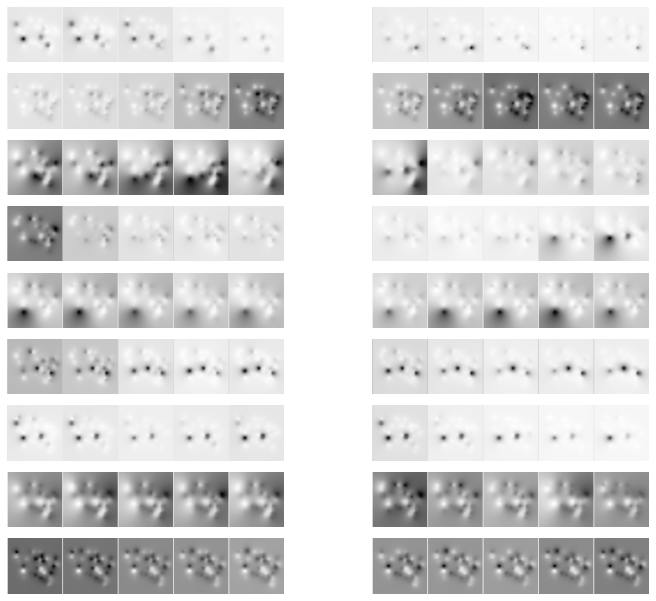

In [8]:
dls.show_batch()

In [9]:
b = dls.one_batch()
explode_types(b)

{tuple: [{pm25.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {pm25.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

## Simple model

In [10]:
model = StackUnstack(SimpleModel())

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [11]:
learn = Learner(dls, model, loss_func=loss_func, cbs=[]).to_fp16()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

In [12]:
x,y = dls.one_batch()

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0063095735386013985)

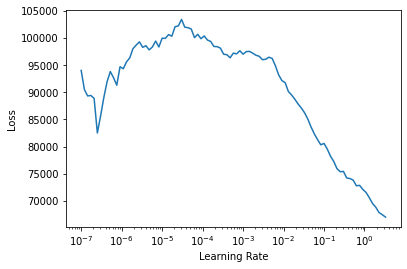

In [13]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,time
0,99550.437500,97637.398438,01:31


In [ ]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [ ]:
len(p), p[0].shape

In [ ]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

In [ ]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)

## A bigger Decoder

We will pass:
- `blur`: to use blur on the upsampling path (this is done by using and a poolling layer and a replication)
- `attn`: to include a self attention layer on the decoder

In [ ]:
model2 = StackUnstack(SimpleModel(szs=[16,64,96], act=partial(nn.LeakyReLU, 0.2, inplace=True),blur=True, attn=True))

We have to reduce batch size as the self attention layer is heavy.

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=8,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [ ]:
learn2 = Learner(dls, model2, loss_func=loss_func, cbs=[]).to_fp16()

In [ ]:
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(10, 1e-4)

In [ ]:
p,t = learn2.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [ ]:
len(p), p[0].shape

In [ ]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

In [ ]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)